# Component 06b: ResNet50 + Spatial Attention (Advanced)

## 🔥 Novel Architecture Enhancement
This notebook adds **Spatial Attention Mechanism** to ResNet50 for improved feature focus.

**Attention Benefits**:
- ✅ Learns WHERE to focus in the image
- ✅ Improves interpretability
- ✅ Better performance on subtle features
- ✅ State-of-the-art for medical imaging

**Citation**: Woo et al. (2018), "CBAM: Convolutional Block Attention Module" 

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json, os, math
from sklearn.utils.class_weight import compute_class_weight

SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
tf.keras.mixed_precision.set_global_policy('mixed_float16')

OUTPUT_DIR = '../outputs'
os.makedirs(f'{OUTPUT_DIR}/models', exist_ok=True)
os.makedirs(f'{OUTPUT_DIR}/training_history', exist_ok=True)
print('✅ Setup complete with mixed precision')

✅ Setup complete with mixed precision


## Configuration

In [2]:
train_df = pd.read_csv('../outputs/train_manifest.csv')
val_df = pd.read_csv('../outputs/val_manifest.csv')

IMG_SIZE, BATCH_SIZE, EPOCHS = (224, 224), 32, 50
NUM_CLASSES = len(train_df['class_label'].unique())
INITIAL_LR, WEIGHT_DECAY, WARMUP_EPOCHS = 1e-3, 1e-4, 5
LABEL_SMOOTHING, GRADIENT_CLIP_NORM = 0.1, 1.0
DROPOUT_RATE_1, DROPOUT_RATE_2, DROPOUT_RATE_3 = 0.3, 0.4, 0.5

print(f'Train: {len(train_df)}, Val: {len(val_df)}, Classes: {NUM_CLASSES}')

Train: 8220, Val: 1761, Classes: 4


## Spatial Attention Module

In [3]:
class SpatialAttention(tf.keras.layers.Layer):
    """Spatial Attention Module - learns WHERE to focus in the image."""
    
    def __init__(self, kernel_size=7, **kwargs):
        super().__init__(**kwargs)
        self.kernel_size = kernel_size
        
    def build(self, input_shape):
        self.conv = tf.keras.layers.Conv2D(
            filters=1,
            kernel_size=self.kernel_size,
            padding='same',
            activation='sigmoid',
            kernel_initializer='he_normal'
        )
        super().build(input_shape)
    
    def call(self, inputs):
        # Generate attention map from channel-wise statistics
        avg_pool = tf.reduce_mean(inputs, axis=-1, keepdims=True)
        max_pool = tf.reduce_max(inputs, axis=-1, keepdims=True)
        concat = tf.concat([avg_pool, max_pool], axis=-1)
        
        # Compute spatial attention weights
        attention = self.conv(concat)
        
        # Apply attention to inputs
        return inputs * attention

print('✅ Spatial Attention Module defined')
print('   - Learns spatial importance across image regions')
print('   - 7×7 conv for large receptive field')
print('   - Sigmoid activation for attention weights [0,1]')

✅ Spatial Attention Module defined
   - Learns spatial importance across image regions
   - 7×7 conv for large receptive field
   - Sigmoid activation for attention weights [0,1]


## Preprocessing & Data

In [4]:
def preprocess(fp, label):
    img = tf.io.read_file(fp)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.keras.applications.resnet50.preprocess_input(img)
    return img, label

aug = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.15),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2),
    tf.keras.layers.RandomBrightness(0.2)
])

def build_dataset(df, augment=False, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((df['filepath'].values, df['class_label'].values))
    ds = ds.map(preprocess, tf.data.AUTOTUNE).cache()
    if augment:
        ds = ds.map(lambda x, y: (aug(x, training=True), y))
    if shuffle:
        ds = ds.shuffle(1000, seed=SEED)
    return ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_ds = build_dataset(train_df, augment=True)
val_ds = build_dataset(val_df, augment=False, shuffle=False)
print('✅ Datasets ready')

2026-01-29 07:06:48.142032: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2026-01-29 07:06:48.142091: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2026-01-29 07:06:48.142101: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.92 GB
2026-01-29 07:06:48.142496: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2026-01-29 07:06:48.142543: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


✅ Datasets ready


## Build ResNet50 + Attention

In [5]:
# Load pretrained base model
base_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(*IMG_SIZE, 3)
)

# Fine-tune last 30 layers
for layer in base_model.layers[:-30]:
    layer.trainable = False

# Build model with spatial attention
inputs = tf.keras.Input(shape=(*IMG_SIZE, 3))

# Extract features from base model
x = base_model(inputs, training=True)

# Reshape for attention (if using global pooling, need to reshape back to spatial)
# For models with global pooling, we'll apply attention before pooling
# So we need to get features before pooling
base_no_pool = tf.keras.applications.ResNet50(
    include_top=False,
    pooling=None,  # No pooling - keep spatial dimensions
    weights='imagenet',
    input_shape=(*IMG_SIZE, 3)
)

for layer in base_no_pool.layers[:-30]:
    layer.trainable = False

# Rebuild with attention
inputs = tf.keras.Input(shape=(*IMG_SIZE, 3))
features = base_no_pool(inputs, training=True)

# Apply Spatial Attention
attention_features = SpatialAttention(kernel_size=7)(features)

# Global pooling after attention
x = tf.keras.layers.GlobalAveragePooling2D()(attention_features)

# Classification head with dropout
x = tf.keras.layers.Dropout(DROPOUT_RATE_1)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(DROPOUT_RATE_2)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(DROPOUT_RATE_3)(x)
outputs = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax', dtype='float32')(x)

model = tf.keras.Model(inputs, outputs)

print(f'✅ ResNet50 + Spatial Attention created')
print(f'   Total params: {model.count_params():,}')
model.summary()

✅ ResNet50 + Spatial Attention created
   Total params: 24,145,767


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_attention               │ (None, 7, 7, 2048)     │            99 │
│ (SpatialAttention)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,145,767 (92.11 MB)

 Trainable params: 15,008,231 (57.25 MB)

 Non-trainable params: 9,137,536 (34.86 MB)

## Label Smoothing Loss

In [6]:
class LabelSmoothingLoss(tf.keras.losses.Loss):
    def __init__(self, num_classes, smoothing=0.1):
        super().__init__()
        self.num_classes = num_classes
        self.smoothing = smoothing
        
    def call(self, y_true, y_pred):
        y_true = tf.cast(y_true, tf.int32)
        y_true_one_hot = tf.one_hot(y_true, self.num_classes)
        y_true_smooth = y_true_one_hot * (1 - self.smoothing) + self.smoothing / self.num_classes
        return tf.keras.losses.categorical_crossentropy(y_true_smooth, y_pred)

loss_fn = LabelSmoothingLoss(NUM_CLASSES, smoothing=LABEL_SMOOTHING)
print(f'✅ Label Smoothing Loss created (ε={LABEL_SMOOTHING})')

✅ Label Smoothing Loss created (ε=0.1)


## Compile

In [7]:
def get_lr_schedule(epoch, lr):
    if epoch < WARMUP_EPOCHS:
        return INITIAL_LR * (epoch + 1) / WARMUP_EPOCHS
    progress = (epoch - WARMUP_EPOCHS) / (EPOCHS - WARMUP_EPOCHS)
    return INITIAL_LR * 0.5 * (1 + math.cos(math.pi * progress))

class_weights = compute_class_weight('balanced', classes=np.unique(train_df['class_label']), y=train_df['class_label'])
class_weight_dict = {i: w for i, w in enumerate(class_weights)}

optimizer = tf.keras.optimizers.AdamW(learning_rate=INITIAL_LR, weight_decay=WEIGHT_DECAY, clipnorm=GRADIENT_CLIP_NORM)
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])
print('✅ Compiled with AdamW + Attention-enhanced architecture')

✅ Compiled with AdamW + Attention-enhanced architecture


## Train

In [8]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(f'{OUTPUT_DIR}/models/resnet50_attention_best.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1),
    tf.keras.callbacks.LearningRateScheduler(get_lr_schedule, verbose=1),
    tf.keras.callbacks.CSVLogger(f'{OUTPUT_DIR}/training_history/resnet50_attention_training.csv')
]

print(f'\n{"="*80}')
print(f'🚀 TRAINING ResNet50 + SPATIAL ATTENTION')
print(f'{"="*80}')
print(f'Novel Feature: Spatial attention learns to focus on important brain regions')
print(f'{"="*80}\n')

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
    class_weight=class_weight_dict,
    verbose=1
)

print(f'\n{"="*80}')
print('✅ TRAINING COMPLETE')
print(f'{"="*80}')


🚀 TRAINING ResNet50 + SPATIAL ATTENTION
Novel Feature: Spatial attention learns to focus on important brain regions


Epoch 1: LearningRateScheduler setting learning rate to 0.0002.
Epoch 1/50


2026-01-29 07:06:53.950875: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - accuracy: 0.5051 - loss: 2.0693
Epoch 1: val_accuracy improved from None to 0.68995, saving model to ../outputs/models/resnet50_attention_best.h5


257/257 ━━━━━━━━━━━━━━━━━━━━ 139s 481ms/step - accuracy: 0.5415 - loss: 1.7857 - val_accuracy: 0.6899 - val_loss: 3.2860 - learning_rate: 2.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.0004.
Epoch 2/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - accuracy: 0.5531 - loss: 1.7340
Epoch 2: val_accuracy did not improve from 0.68995
257/257 ━━━━━━━━━━━━━━━━━━━━ 130s 488ms/step - accuracy: 0.5603 - loss: 1.5180 - val_accuracy: 0.6894 - val_loss: 2.7839 - learning_rate: 4.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0006000000000000001.
Epoch 3/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step - accuracy: 0.6014 - loss: 1.4305
Epoch 3: val_accuracy did not improve from 0.68995
257/257 ━━━━━━━━━━━━━━━━━━━━ 144s 544ms/step - accuracy: 0.6021 - loss: 1.5762 - val_accuracy: 0.6899 - val_loss: 1.3996 - learning_rate: 6.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0008.
Epoch 4/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step - accuracy:

257/257 ━━━━━━━━━━━━━━━━━━━━ 163s 619ms/step - accuracy: 0.6279 - loss: 8.1610 - val_accuracy: 0.6922 - val_loss: 0.9151 - learning_rate: 9.9513e-04

Epoch 9: LearningRateScheduler setting learning rate to 0.0009890738003669028.
Epoch 9/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step - accuracy: 0.6188 - loss: 5.3355
Epoch 9: val_accuracy did not improve from 0.69222
257/257 ━━━━━━━━━━━━━━━━━━━━ 138s 523ms/step - accuracy: 0.6236 - loss: 6.1378 - val_accuracy: 0.6899 - val_loss: 1.0114 - learning_rate: 9.8907e-04

Epoch 10: LearningRateScheduler setting learning rate to 0.0009806308479691594.
Epoch 10/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - accuracy: 0.6203 - loss: 6.8000
Epoch 10: val_accuracy did not improve from 0.69222
257/257 ━━━━━━━━━━━━━━━━━━━━ 139s 525ms/step - accuracy: 0.6221 - loss: 8.5091 - val_accuracy: 0.6899 - val_loss: 0.8952 - learning_rate: 9.8063e-04

Epoch 11: LearningRateScheduler setting learning rate to 0.0009698463103929542.
Epoch 11/50
257/257 ━━━━━━━━━━━

257/257 ━━━━━━━━━━━━━━━━━━━━ 169s 642ms/step - accuracy: 0.6427 - loss: 12.9197 - val_accuracy: 0.6939 - val_loss: 0.9464 - learning_rate: 7.5000e-04

Epoch 22: LearningRateScheduler setting learning rate to 0.0007191855733945387.
Epoch 22/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 548ms/step - accuracy: 0.6577 - loss: 7.1917
Epoch 22: val_accuracy did not improve from 0.69392
257/257 ━━━━━━━━━━━━━━━━━━━━ 164s 623ms/step - accuracy: 0.6584 - loss: 8.4854 - val_accuracy: 0.6899 - val_loss: 1.1071 - learning_rate: 7.1919e-04

Epoch 23: LearningRateScheduler setting learning rate to 0.0006873032967079561.
Epoch 23/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 567ms/step - accuracy: 0.6657 - loss: 9.4568
Epoch 23: val_accuracy did not improve from 0.69392
257/257 ━━━━━━━━━━━━━━━━━━━━ 169s 643ms/step - accuracy: 0.6668 - loss: 9.5274 - val_accuracy: 0.6905 - val_loss: 1.0370 - learning_rate: 6.8730e-04

Epoch 24: LearningRateScheduler setting learning rate to 0.0006545084971874737.
Epoch 24/50
257/257 ━━━━━━━

## Save Results

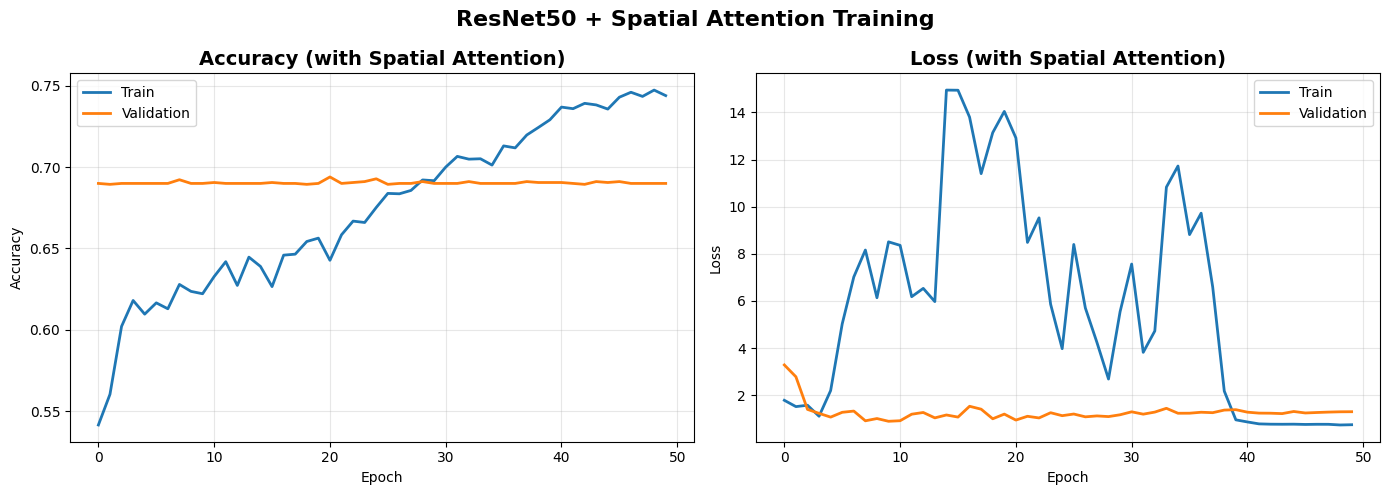


📊 Results:
   Best Val Accuracy: 0.6939
   Final Train Acc: 0.7439
   Final Val Acc: 0.6899

💾 Saved to: ../outputs/models/resnet50_attention_best.h5

🔬 Compare with base ResNet50 to measure attention impact!


In [9]:
# Save history
with open(f'{OUTPUT_DIR}/training_history/resnet50_attention_history.json', 'w') as f:
    json.dump({k: [float(v) for v in vals] for k, vals in history.history.items()}, f, indent=2)

import pandas as pd
pd.DataFrame(history.history).to_csv(f'{OUTPUT_DIR}/training_history/resnet50_attention_history.csv', index=False)

# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(history.history['accuracy'], label='Train', linewidth=2)
ax1.plot(history.history['val_accuracy'], label='Validation', linewidth=2)
ax1.set_title('Accuracy (with Spatial Attention)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(alpha=0.3)

ax2.plot(history.history['loss'], label='Train', linewidth=2)
ax2.plot(history.history['val_loss'], label='Validation', linewidth=2)
ax2.set_title('Loss (with Spatial Attention)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(alpha=0.3)

plt.suptitle(f'ResNet50 + Spatial Attention Training', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/training_history/resnet50_attention_curves.png', dpi=200)
plt.show()

print(f'\n📊 Results:')
print(f'   Best Val Accuracy: {max(history.history["val_accuracy"]):.4f}')
print(f'   Final Train Acc: {history.history["accuracy"][-1]:.4f}')
print(f'   Final Val Acc: {history.history["val_accuracy"][-1]:.4f}')
print(f'\n💾 Saved to: {OUTPUT_DIR}/models/resnet50_attention_best.h5')
print(f'\n🔬 Compare with base ResNet50 to measure attention impact!')